In [1]:
import dolfin as dl
import hippylib as hl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from spin.core import problem
from spin.fenics import converter
from spin.hippylib import hessian, laplace, misfit, optimization, prior

sns.set_theme(style="ticks")

In [2]:
mesh = dl.IntervalMesh(500, -1.5, 1.5)
problem_settings = problem.SPINProblemSettings(
    mesh=mesh,
    pde_type="mean_exit_time_moments",
    inference_type="drift_and_diffusion",
)
problem_builder = problem.SPINProblemBuilder(problem_settings)
spin_problem = problem_builder.build()

In [3]:
parameter_coordinates = spin_problem.coordinates_parameters
solution_coordinates = spin_problem.coordinates_variables
true_parameter = converter.create_dolfin_function(
    ("-2*std::pow(x[0],3) + 3*x[0]", "std::log(std::pow(x[0],2) + 2)"),
    spin_problem.function_space_parameters,
)
true_parameter = converter.convert_to_numpy(
    true_parameter.vector(), spin_problem.function_space_parameters
)
true_solution = spin_problem.solve_forward(true_parameter)
data_stride = 10
data_locations = solution_coordinates[::data_stride]
data_values_mfpt1 = true_solution[0, ::data_stride]
data_values_mfpt2 = true_solution[1, ::data_stride]
rng = np.random.default_rng(seed=0)
noise_std = 0.01
noise = rng.normal(loc=0, scale=noise_std, size=data_values_mfpt1.size)
data_values_mfpt1 = data_values_mfpt1 + noise
data_values_mfpt2 = data_values_mfpt2 + noise

In [4]:
right_hand_side = np.ones(true_solution.shape)
true_adjoint = spin_problem.solve_adjoint(true_solution, true_parameter, right_hand_side)

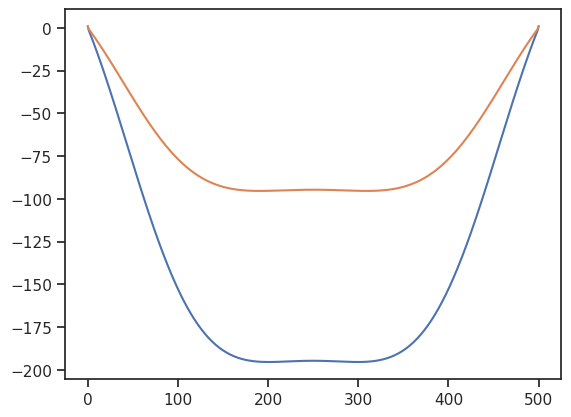

In [10]:
plt.plot(true_adjoint[0, :])
plt.plot(true_adjoint[1, :])

In [ ]:
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), layout="constrained")
axs[0].plot(parameter_coordinates, true_parameter[0, :])
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_title("True drift")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$b(x)$")
axs[1].plot(parameter_coordinates, true_parameter[1, :])
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_title("True log squared diffusion")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\log(\sigma^2(x))$")
axs[2].plot(solution_coordinates, true_solution[0, :], label=r"$\tau_1$")
axs[2].plot(solution_coordinates, true_solution[1, :], label=r"$\tau_2$")
axs[2].scatter(data_locations, data_values_mfpt1, color="firebrick", label=r" data $\tau_1$")
axs[2].scatter(data_locations, data_values_mfpt2, color="firebrick", label=r" data $\tau_2$")
axs[2].set_xlim(-1.5, 1.5)
axs[2].set_title("True solution")
axs[2].set_xlabel(r"$x$")
axs[2].set_ylabel(r"$\tau(x)$")
axs[2].legend()

In [ ]:
prior_settings = prior.PriorSettings(
    function_space=spin_problem.function_space_parameters,
    mean=("-x[0]", "1"),
    variance=("1", "0.05"),
    correlation_length=("1", "1"),
    robin_bc=False,
)
prior_builder = prior.BilaplacianVectorPriorBuilder(prior_settings)
spin_prior = prior_builder.build()
prior_variance = spin_prior.compute_variance_with_boundaries(
    method="Randomized", num_eigenvalues_randomized=100
)

In [ ]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].plot(parameter_coordinates, spin_prior.mean_array[0, :], label="Mean")
axs[0].fill_between(
    parameter_coordinates.flatten(),
    spin_prior.mean_array[0, :] - 1.96 * np.sqrt(prior_variance[0, :]),
    spin_prior.mean_array[0, :] + 1.96 * np.sqrt(prior_variance[0, :]),
    alpha=0.3,
    label="95% CI",
)
axs[0].set_title("Prior drift")
axs[0].set_xlim(-1.5, 1.5)
axs[0].legend()

axs[1].plot(parameter_coordinates, spin_prior.mean_array[1, :], label="Mean")
axs[1].fill_between(
    parameter_coordinates.flatten(),
    spin_prior.mean_array[1, :] - 1.96 * np.sqrt(prior_variance[1, :]),
    spin_prior.mean_array[1, :] + 1.96 * np.sqrt(prior_variance[1, :]),
    alpha=0.3,
    label="95% CI",
)
axs[1].set_title("Prior log squared diffusion")
axs[1].set_xlim(-1.5, 1.5)
axs[1].legend()

In [ ]:
misfit_settings = misfit.MisfitSettings(
    function_space=spin_problem.function_space_variables,
    observation_points=2 * (data_locations,),
    observation_values=(data_values_mfpt1, data_values_mfpt2),
    noise_variance=2 * (np.ones(data_locations.size) * noise_std**2,),
)
misfit_builder = misfit.MisfitBuilder(misfit_settings)
spin_misfit = misfit_builder.build()

In [ ]:
inference_model = hl.Model(
    spin_problem.hippylib_variational_problem, spin_prior.hippylib_prior, spin_misfit
)

In [ ]:
optimization_settings = optimization.SolverSettings(
    relative_tolerance=1e-8,
    absolute_tolerance=1e-4,
    max_num_line_search_iterations=100,
    verbose=True,
)
initial_guess = spin_prior.mean_array
newton_solver = optimization.NewtonCGSolver(optimization_settings, inference_model)
solver_solution = newton_solver.solve(initial_guess)
print("Termination reason:", solver_solution.termination_reason)

In [ ]:
hessian_settings = hessian.LowRankHessianSettings(
    num_eigenvalues=30,
    num_oversampling=40,
    inference_model=inference_model,
    evaluation_point=[
        solver_solution.forward_solution,
        solver_solution.optimal_parameter,
        solver_solution.adjoint_solution,
    ],
)
eigenvalues, eigenvectors = hessian.compute_low_rank_hessian(hessian_settings)

In [ ]:
index_vector = np.arange(1, eigenvalues.size + 1)
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.semilogy(index_vector, eigenvalues, marker="o")
ax.set_title("Eigenvalues")
ax.set_xticks((1, 5, 10, 15, 20, 25, 30))
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\lambda_i$")

In [ ]:
laplace_approximation_settings = laplace.LowRankLaplaceApproximationSettings(
    inference_model=inference_model,
    mean=solver_solution.optimal_parameter,
    low_rank_hessian_eigenvalues=eigenvalues,
    low_rank_hessian_eigenvectors=eigenvectors,
)
laplace_approximation = laplace.LowRankLaplaceApproximation(laplace_approximation_settings)
posterior_variance = laplace_approximation.compute_pointwise_variance(
    method="Randomized", num_eigenvalues_randomized=100
)

posterior_predictive = spin_problem.solve_forward(solver_solution.optimal_parameter)

In [ ]:
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), layout="constrained")
axs[0].plot(parameter_coordinates, solver_solution.optimal_parameter[0, :], label="Mean")
axs[0].fill_between(
    parameter_coordinates.flatten(),
    solver_solution.optimal_parameter[0, :] - 1.96 * np.sqrt(posterior_variance[0, :]),
    solver_solution.optimal_parameter[0, :] + 1.96 * np.sqrt(posterior_variance[0, :]),
    alpha=0.3,
    label="95% CI",
)
axs[0].set_title("Laplace approximation drift")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$b(x)$")
axs[0].set_xlim((-1.5, 1.5))
axs[0].legend()

axs[1].plot(parameter_coordinates, solver_solution.optimal_parameter[1, :], label="Mean")
axs[1].fill_between(
    parameter_coordinates.flatten(),
    solver_solution.optimal_parameter[1, :] - 1.96 * np.sqrt(posterior_variance[1, :]),
    solver_solution.optimal_parameter[1, :] + 1.96 * np.sqrt(posterior_variance[1, :]),
    alpha=0.3,
    label="95% CI",
)
axs[1].set_title("Laplace approximation log squared diffusion")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\log(\sigma^2(x))$")
axs[1].set_xlim((-1.5, 1.5))
axs[1].legend()

axs[2].plot(solution_coordinates, posterior_predictive[0, :], label=r"$\tau_1$")
axs[2].plot(solution_coordinates, posterior_predictive[1, :], label=r"$\tau_2$")
axs[2].scatter(data_locations, data_values_mfpt1, color="firebrick", label=r" data $\tau_1$")
axs[2].scatter(data_locations, data_values_mfpt2, color="firebrick", label=r" data $\tau_2$")
axs[2].set_xlim(-1.5, 1.5)
axs[2].set_title("True solution")
axs[2].set_xlabel(r"$x$")
axs[2].set_ylabel(r"$\tau(x)$")
axs[2].legend()